In [1]:
import os
import torch
import argparse
import itertools
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torchvision.utils import save_image
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import get_rank, init_process_group, destroy_process_group, all_gather, get_world_size
from torch import Tensor
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from glob import glob
from torch.utils.data.distributed import DistributedSampler
import random
from conditionDiffusion.unet import Unet
from conditionDiffusion.embedding import ConditionalEmbedding
from conditionDiffusion.utils import get_named_beta_schedule
from conditionDiffusion.diffusion import GaussianDiffusion
from conditionDiffusion.Scheduler import GradualWarmupScheduler
from PIL import Image
import torchvision
print(f"GPUs used:\t{torch.cuda.device_count()}")
device = torch.device("cuda",6)
print(f"Device:\t\t{device}")
tf=transforms.ToTensor()
topilimage = torchvision.transforms.ToPILImage()
import pytorch_model_summary as tms


GPUs used:	8
Device:		cuda:6


In [8]:
class_list=['NT_epithelial','NT_immune','NT_stroma','TP_in_situ','TP_invasive']
params={'image_size':1024,
        'lr':2e-5,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':1,
        'epochs':1000,
        'n_classes':None,
        'data_path':'../../data/normalization_type/BR/image/',
        'image_count':5000,
        'inch':3,
        'modch': 128,
        'outch': 3,
        'chmul': [1, 2, 2, 4, 4, 8],
        'numres':4,
        'dtype':torch.float32,
        'cdim':1024*1024,
        'useconv':False,
        'droprate':0.1,
        'T':1000,
        'w':1.8,
        'v':0.3,
        'multiplier':1,
        'threshold':0.1,
        'ddim':True,
        }


In [4]:
trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

def transback(data:Tensor) -> Tensor:
    return data / 2 + 0.5

class CustomDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self,parmas, images,label):
        
        self.images = images
        self.args=parmas
        self.label=label
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            image = transform(image)
            label = transform(label)
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            image = transform(image)
            label = transform(label)
        return image,label
    
    def __getitem__(self, index):
        image=self.images[index]
        label=self.label[index]
        image,label = self.trans(image,label)
        return image,label
    
    def __len__(self):
        return len(self.images)


image_list = glob(params['data_path']+'/*.jpeg')


train_images = torch.zeros(
    (len(image_list), params['inch'], params['image_size'], params['image_size']))
train_label = torch.zeros(
    (len(image_list), params['image_size'], params['image_size']))
for i in tqdm(range(10)):
    train_images[i] = tf(Image.open(image_list[i]).convert(
        'RGB').resize((params['image_size'], params['image_size'])))*2-1
    npy_label = np.load(image_list[i].replace(
        '/image', '/mask').replace('jpeg', 'npy'))

    train_label[i] = torch.tensor(npy_label).float()

train_dataset = CustomDataset(params, train_images, train_label)
dataloader = DataLoader(
    train_dataset, batch_size=params['batch_size'], shuffle=True)

100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


In [9]:
net = Unet(in_ch = params['inch'],
            mod_ch = params['modch'],
            out_ch = params['outch'],
            ch_mul = params['chmul'],
            num_res_blocks = params['numres'],
            cdim = params['cdim'],
            use_conv = params['useconv'],
            droprate = params['droprate'],
            dtype = params['dtype']
            ).to(device)
betas = get_named_beta_schedule(num_diffusion_timesteps = params['T'])
diffusion = GaussianDiffusion(
                    dtype = params['dtype'],
                    model = net,
                    betas = betas,
                    w = params['w'],
                    v = params['v'],
                    device = device
                )
optimizer = torch.optim.AdamW(
                itertools.chain(
                    diffusion.model.parameters()
                ),
                lr = params['lr'],
                weight_decay = 1e-6
            )


cosineScheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
warmUpScheduler = GradualWarmupScheduler(
                        optimizer = optimizer,
                        multiplier = params['multiplier'],
                        warm_epoch = 50,
                        after_scheduler = cosineScheduler,
                        last_epoch = 0
                    )
# checkpoint=torch.load(f'../../model/conditionDiff/BR/ckpt_35_checkpoint.pt',map_location=device)
# diffusion.model.load_state_dict(checkpoint['net'])

checkpoint=0

In [ ]:
scaler = torch.cuda.amp.GradScaler()

for epc in range(params['epochs']):
    diffusion.model.train()
    total_loss=0
    steps=0
    with tqdm(dataloader, dynamic_ncols=True) as tqdmDataLoader:
        for img, lab in tqdmDataLoader:
            b = img.shape[0]
            
            x_0 = img.to(device)
            lab = lab.to(device)
            cemb = lab
            loss = diffusion.trainloss(x_0, cemb = cemb)
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            steps+=1
            total_loss+=loss.item()
            tqdmDataLoader.set_postfix(
                ordered_dict={
                    "epoch": epc + 1,
                    "loss: ": total_loss/steps,
                    "batch per device: ":x_0.shape[0],
                    "img shape: ": x_0.shape[1:],
                    "LR": optimizer.state_dict()['param_groups'][0]["lr"]
                }
            )
    warmUpScheduler.step()
    
    diffusion.model.eval()
    # generating samples
    # The model generate 80 pictures(8 per row) each time
    # pictures of same row belong to the same class
    all_samples = []
    each_device_batch =len(class_list)
    count=1
    with torch.no_grad():
        for i, (img, lab1) in enumerate(dataloader):
            if i==0:
                lab = lab1.to(device)
            elif i < count:
                lab = torch.cat((lab,lab1.to(device)),0).to(device)
            else:
                break
        cemb =lab
        genshape = (count, 3, params['image_size'], params['image_size'])
        if params['ddim']:
            generated = diffusion.ddim_sample(
                genshape, 100, 0.5, 'quadratic', cemb=cemb)
        else:
            generated = diffusion.sample(genshape, cemb = cemb)
        generated=transback(generated)
        for i in range(len(lab)):
            img_pil = topilimage(generated[i].cpu())
            img_pil.save(f'../../result/mask_synth/{epc}_{i}.png')

        # save checkpoints
        checkpoint = {
                            'net':diffusion.model.state_dict(),
                            'optimizer':optimizer.state_dict(),
                            'scheduler':warmUpScheduler.state_dict()
                        }
    torch.save(checkpoint, f'../../model/mask_synth/BR/ckpt_{epc+1}_checkpoint.pt')
    torch.cuda.empty_cache()
    

In [30]:
count=1
with torch.no_grad():
    for i, (img, lab1) in enumerate(dataloader):
        if i==0:
            lab = lab1.to(device)
        elif i < count:
            lab = torch.cat((lab,lab1.to(device)),0).to(device)
        else:
            break
    cemb =lab
    genshape = (count, 3, params['image_size'], params['image_size'])
    if params['ddim']:
        generated = diffusion.ddim_sample(
            genshape, 100, 0.5, 'quadratic', cemb=cemb)
    else:
        generated = diffusion.sample(genshape, cemb = cemb)
    generated=transback(generated)
    for i in range(len(lab)):
        img_tensor=torch.zeros((3,params['image_size'],params['image_size']))
        img_tensor[0]=torch.where(lab[i]==1,1,0)
        img_tensor[1]=torch.where(lab[i]==2,1,0)
        img_tensor[2]=torch.where(lab[i]==3,1,0)
        img_tensor[0]=torch.where(lab[i]==4,1,0)
        img_tensor[1]=torch.where(lab[i]==4,1,0)
        img_tensor[1]=torch.where(lab[i]==5,1,0)
        img_tensor[2]=torch.where(lab[i]==5,1,0)
        img_pil = topilimage(torch.cat((generated[i].cpu(),img_tensor.float()),dim=2))
        img_pil.save(f'../../result/mask_synth/{epc}_{i}.png')

    # save checkpoints
    checkpoint = {
                        'net':diffusion.model.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'scheduler':warmUpScheduler.state_dict()
                    }

Start generating(ddim)...


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:31<00:00,  1.56s/it]

ending sampling process(ddim)...


NameError: name 'epc' is not defined

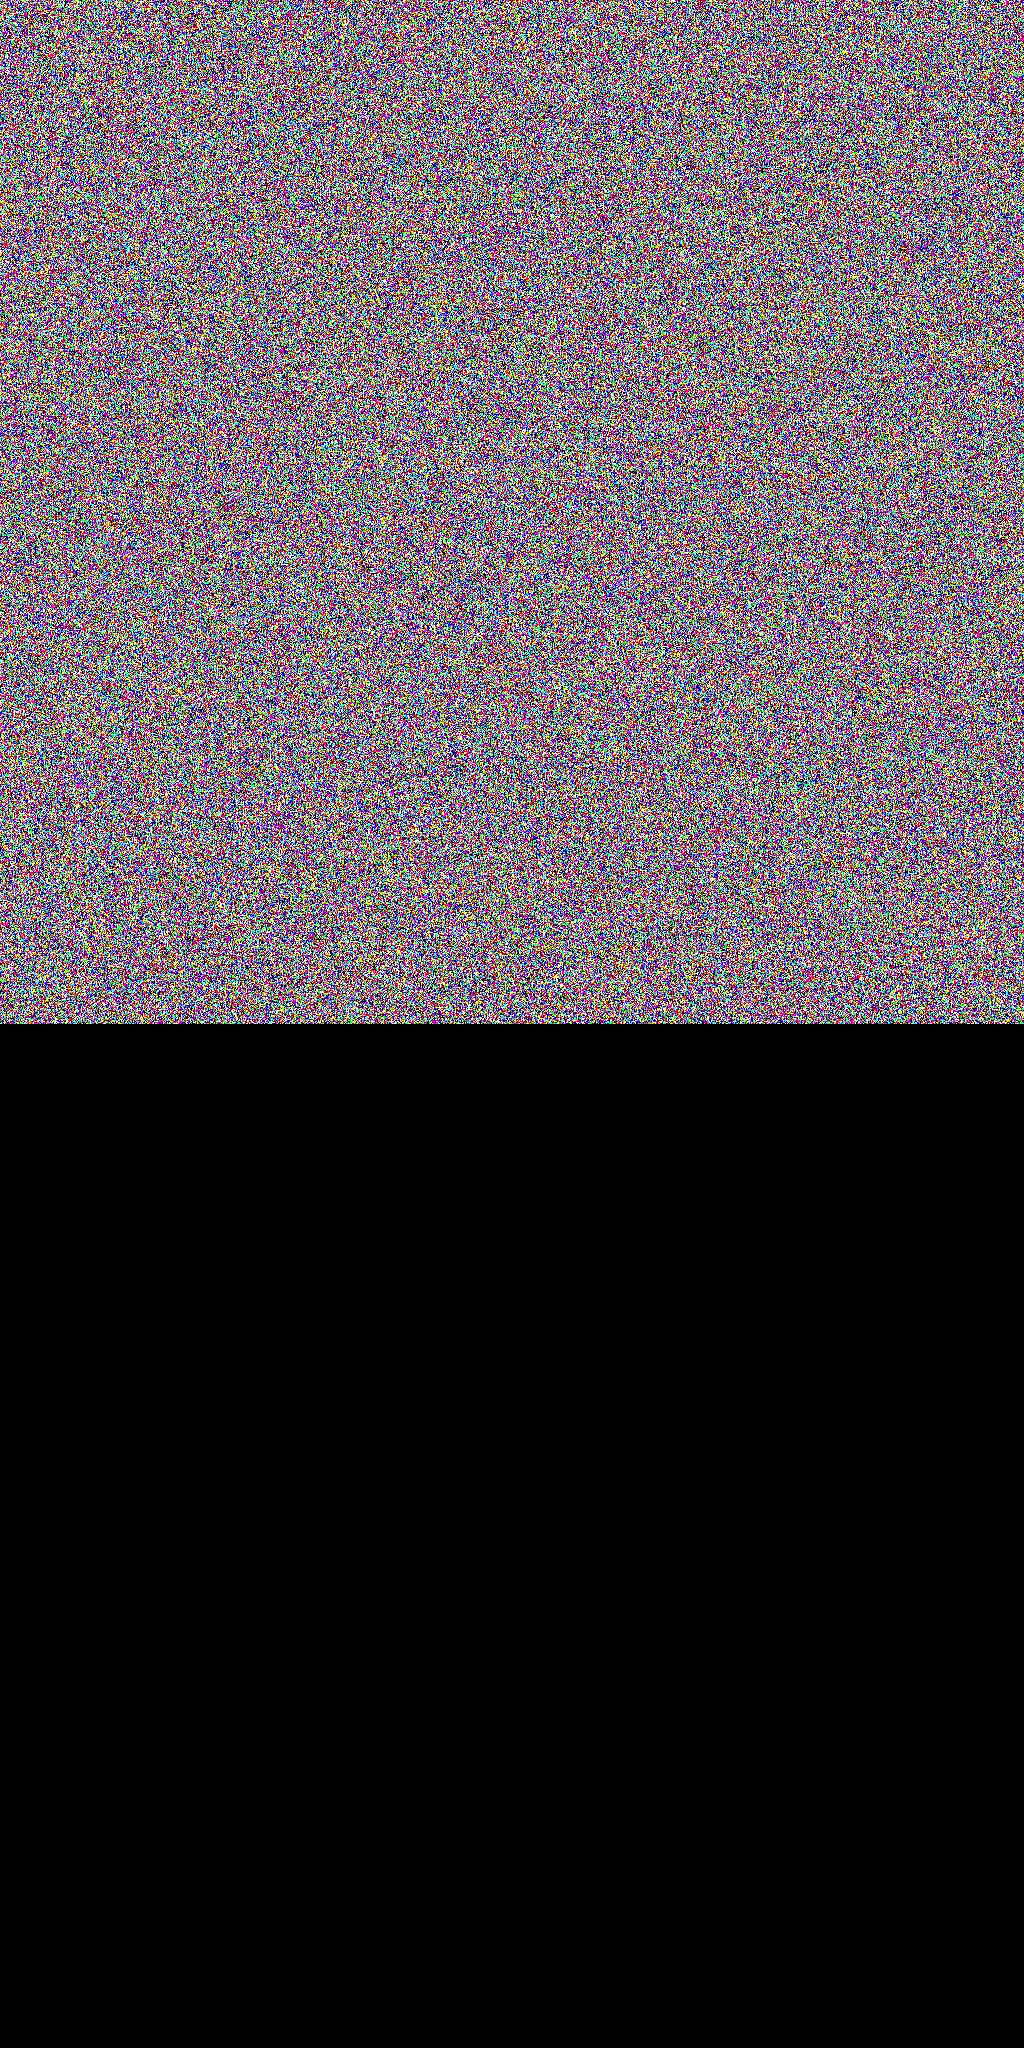

In [32]:
img_pil

In [ ]:
all_samples = []
    each_device_batch =len(class_list)
    count=1
    with torch.no_grad():
        for i, (img, lab1) in enumerate(dataloader):
            if i==0:
                lab = lab1.to(device)
            elif i < count:
                lab = torch.cat((lab,lab1.to(device)),0).to(device)
            else:
                break
        cemb =lab
        genshape = (count, 3, params['image_size'], params['image_size'])
        if params['ddim']:
            generated = diffusion.ddim_sample(
                genshape, 100, 0.5, 'quadratic', cemb=cemb)
        else:
            generated = diffusion.sample(genshape, cemb = cemb)
        generated=transback(generated)
        for i in range(len(lab)):
            img_pil = topilimage(generated[i].cpu())
            img_pil.save(f'../../result/mask_synth/{epc}_{i}.png')

        # save checkpoints
        checkpoint = {
                            'net':diffusion.model.state_dict(),
                            'optimizer':optimizer.state_dict(),
                            'scheduler':warmUpScheduler.state_dict()
                        }
    torch.save(checkpoint, f'../../model/mask_synth/BR/ckpt_{epc+1}_checkpoint.pt')
    torch.cuda.empty_cache()